**Importing the packages**

In [105]:
#from mpmath import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.signal import find_peaks

**Defining operator to make inverse Laplace Transform**

In [87]:
def Talbot(F, t_vals, N=16):
    # https://code.activestate.com/recipes/576934-numerical-inversion-of-the-laplace-transform-using/
    """
    Computes the inverse Laplace transform using Talbot's method for multiple time values.

    Parameters:
        F (callable): Function in the Laplace domain (F(s)).
        t_vals (array-like): Array of time values to evaluate the inverse transform.
        N (int): Number of terms in the summation (higher = better accuracy).

    Returns:
        np.ndarray: Approximated inverse Laplace transform values for all `t_vals`.
    """
    t_vals = np.asarray(t_vals, dtype=np.float64)  # Ensure it's a numpy array
    results = np.zeros_like(t_vals, dtype=np.float64)

    # Step size
    h = 2 * np.pi / N
    shift = 0.0  # Adjust this if needed for poles on the positive real axis

    for idx, t in enumerate(t_vals):
        if t <= 1e-10:
            results[idx] = 0.0  # Assign NaN for invalid t values
            continue

        ans = 0.0
        for k in range(N):
            theta = -np.pi + (k + 0.5) * h  # Midpoint rule
            cot_term = 1 / np.tan(0.6407 * theta)  # Avoid division issues with cotangent

            # Talbot contour transformation
            z = shift + (N / t) * (0.5017 * theta * cot_term - 0.6122 + 0.2645j * theta)
            dz = (N / t) * (-0.5017 * 0.6407 * theta / np.sin(0.6407 * theta) ** 2 + 0.5017 * cot_term + 0.2645j)

            # Debugging: Check for NaN or inf in F(z) or dz
            if np.isnan(F(z)) or np.isinf(F(z)) or np.isnan(dz) or np.isinf(dz):
                print(f"Warning: F(z) or dz is NaN/inf at t = {t}, z = {z}")
                continue

            ans += np.exp(z * t) * F(z) * dz

        results[idx] = (h / (2j * np.pi) * ans).real  # Store the computed value

    return results


**Defining the Class that does the math for us**

In [132]:
class CVCurrent:

    def __init__(self,kmax = 1e5,c_tot = 0.16,kp = 0.0028,k_p = 0.0015,kf = 0.0008,k_f = 0.0003 ,DO = 3.2e-5,DR =2.7e-5 ,k0 = 2.6*10**(-4), alpha = 0.42 ,A = 28e-4 , F = 96485.3321 , R = 1.38649*10**(-23) ,T = 298.15 ,n = 1,d = 0.5 ):
        self.A = A
        self.F = F
        self.R = R
        self.T = T
        self.n = n
        self.c = c_tot
        self.alpha = alpha
        self.Kp = kp/k_p
        self.Kf = kf/k_f
        self.p = kp + k_p
        self.f = kf+k_f
        self.DO = DO
        self.DR = DR
        self.km = kmax
        self.k0 = k0
        self.d = d

    def __call__(self,t,epsilon):
        I = []
        delta = t[1]-t[0]

         # Generate logarithmic time grid for G and Y
        t_log = np.logspace(-5, 5, 300)  # 300 points from 10^-5 to 10^5
        G_log = self.FuncG(t_log)
        Y_log = self.FuncY(t_log)

        # Create cubic spline interpolators
        G_spline = CubicSpline(t_log, G_log)
        Y_spline = CubicSpline(t_log, Y_log)

        # Interpolate at the desired time points
        G = G_spline(t)
        Y = Y_spline(t)


        #G = self.FuncG(t)
        #Y = self.FuncY(t)
        

        for i in range(len(t)):

            term1 = self.km/(self.km + self.k0*np.exp(self.alpha*epsilon[i]))*1/(1+self.Kp) 
            term11 = np.sqrt(self.DR)/self.k0 * np.exp(-self.alpha*epsilon[i]) + (self.km)/(self.km+self.k0*np.exp(self.alpha*epsilon[i]))*G[1] + (self.km)/(self.km + self.k0*np.exp(-(1-self.alpha)*epsilon[i]))*np.sqrt(self.DR/self.DO) * Y[1]*np.exp(-epsilon[i])
            I1 = (self.n*self.F*self.A * self.c * self.Kp * np.sqrt(self.DR))

            term2 = -self.km/(self.km + self.k0*np.exp(-(1-self.alpha)*epsilon[i]))*np.exp(-epsilon[i])/(1+self.Kf) * (np.sqrt(self.DR))
            term22 = np.sqrt(self.DR)/self.k0 * np.exp(-self.alpha*epsilon[i]) + (self.km)/(self.km+self.k0*np.exp(self.alpha*epsilon[i]))*G[1] + (self.km)/(self.km + self.k0*np.exp(-(1-self.alpha)*epsilon[i]))*np.sqrt(self.DR/self.DO) * Y[1]*np.exp(-epsilon[i])
            I2 = 0
            for j in range(1,i-1):
                dY = Y[i-j+1] - Y[i-j]
                dG = G[i-j+1] - G[i-j]
                I1 -= I[j]*dG*(self.Kp + np.exp( delta*self.p*(i-j)))
                I2 += I[j]*dY*(1 + self.Kf*np.exp(-delta*self.f*(i-j)))

            I.append(I1*term1/term11 + term2/term22 * I2)

        return np.array(I)
    
    def FuncG(t):

        raise NotImplemented
    
    def FuncY(t):

        raise NotImplemented    

In [96]:
class Planar_Semi_Inf(CVCurrent):

    def __init__(self,**kwargs):
        super().__init__(**kwargs)

    def FuncG(self,t):

        GLaplace = lambda s: 1/np.sqrt(s)*(1/s)

        return Talbot(GLaplace, t , N=16)
    
    def FuncY(self,t):

        YLaplace = lambda s: 1/np.sqrt(s + self.p )*(1/s)

        Y =  Talbot(YLaplace, t , N=16)

        return Y

**Let's First try to calculate something we know**

In [99]:
# Simulating CV Data

cv = Planar_Semi_Inf()

t = np.linspace(1e-3,10,500)
epsilon = -10 + 10*t
# Compute current response
I = cv(t, epsilon)

t2 = np.linspace(1e-3,10,5000)
epsilon2 = -10 + 10*t2
I2 = cv(t2, epsilon2)

t3 = np.linspace(1e-3,10,10000)
epsilon3 = -10 + 10*t3
I3 = cv(t3, epsilon3)

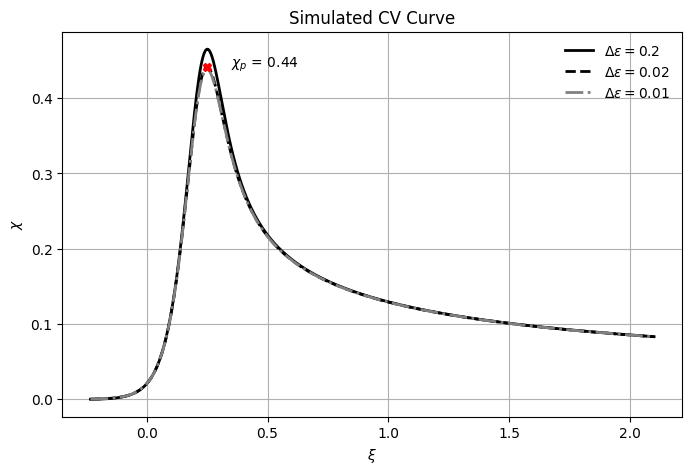

In [128]:
# Plot CV Graph
c = 0.16
A = 28e-4
F = 96485.3321
R = 1.38649e-23
T = 298.15
n = 1
D = 2.7e-5
scan_rate = 10

plt.figure(figsize=(8, 5))
plt.plot(epsilon*n*F/(R*T)*1e-27 , I / (n*F*A*c) * np.sqrt(R*T/(n*F*D*scan_rate))*1e13, '-',color='black', linewidth=2 , label = f'$\Delta \epsilon = {round(epsilon[2]-epsilon[1],1)}$')
plt.plot(epsilon2*n*F/(R*T)*1e-27 , I2 / (n*F*A*c) * np.sqrt(R*T/(n*F*D*scan_rate))*1e13, '--',color='black', linewidth=2, label = f'$\Delta \epsilon = {round(epsilon2[2]-epsilon2[1],2)}$')
plt.plot(epsilon3*n*F/(R*T)*1e-27 , I3 / (n*F*A*c) * np.sqrt(R*T/(n*F*D*scan_rate))*1e13, '-.',color='gray', linewidth=2, label = f'$\Delta \epsilon = {round(epsilon3[2]-epsilon3[1],3)}$')

peaks,_ = find_peaks(I2)

plt.plot(epsilon2[peaks]*n*F/(R*T)*1e-27 , I2[peaks] / (n*F*A*c) * np.sqrt(R*T/(n*F*D*scan_rate))*1e13,'X',color='red')


plt.annotate(f'$\\chi_p$ = {round(I2[peaks[0]] / (n*F*A*c) * np.sqrt(R*T/(n*F*D*scan_rate))*1e13,2)}',xy = (0,0),
              xytext=(epsilon2[peaks]*n*F/(R*T)*1e-27 + 0.1 ,I2[peaks] / (n*F*A*c) * np.sqrt(R*T/(n*F*D*scan_rate))*1e13))

plt.xlabel("$\\xi $")
plt.ylabel("$\chi$")
plt.title("Simulated CV Curve")
plt.grid(True)
plt.legend(frameon=False)

plt.show()


**Know apply it to real system**

To do it we need to have a finite electrode, so we need to define it

In [133]:
class Planar_Finite(CVCurrent):

    def __init__(self,**kwargs):
        super().__init__(**kwargs)

    def FuncG(self,t):

        GLaplace = lambda s: (np.cosh(self.d * np.sqrt(s/self.DR) )/ (np.sinh(self.d * np.sqrt(s/self.DR) ) + 1e-10 ) )/np.sqrt(s)*(1/s)

        return Talbot(GLaplace, t , N=16)
    
    def FuncY(self,t):

        YLaplace = lambda s: (np.cosh(self.d * np.sqrt(s/self.DO) )/ (np.sinh(self.d * np.sqrt(s/self.DO) ) + 1e-10 ) )/np.sqrt(s)*(1/s)

        Y =  Talbot(YLaplace, t , N=16)

        return Y

In [135]:
def generate_epsilon(scan_rate, E_start, E_peak, num_points):
    """
    Generates a triangular potential waveform for cyclic voltammetry.
    
    scan_rate: Rate of potential change (V/s)
    E_start: Initial potential (V)
    E_peak: Peak potential (V)
    num_points: Total number of points in the scan
    
    Returns:
        t: Time array
        epsilon: Potential array
    """
    # Half the time for forward and backward scans
    num_half = num_points // 2  

    # Time step based on scan rate
    t_up = np.linspace(1e-3, (E_peak - E_start) / scan_rate, num_half)  # Forward scan
    t_down = np.linspace(t_up[-1], 2 * t_up[-1], num_half)           # Reverse scan
    t = np.concatenate((t_up, t_down))  # Full time array

    # Generate potential
    epsilon_up = E_start + scan_rate * t_up  # Forward potential
    epsilon_down = E_peak - scan_rate * (t_down - t_up[-1])  # Reverse potential
    epsilon = np.concatenate((epsilon_up, epsilon_down))  # Full potential

    return t, epsilon


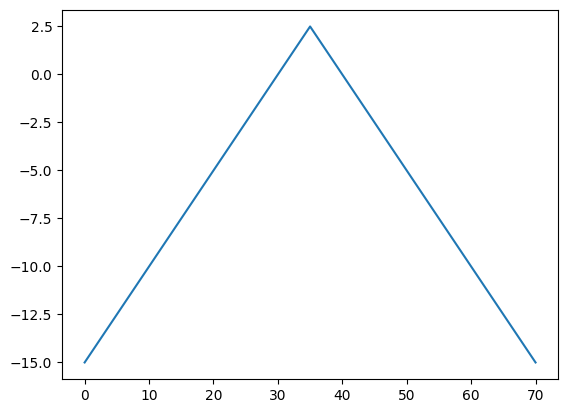

In [144]:

fp = Planar_Finite(d=50e-6)
scan_rate = 0.5  # V/s
E_start = -15   # Initial potential (V)
E_peak = 2.5    # Peak potential (V)
num_points = 5000  # Number of time steps

t, epsilon = generate_epsilon(scan_rate, E_start, E_peak, num_points)
#t = np.linspace(1e-3,10,500)
#epsilon = -10 + 10*t
plt.plot(t,epsilon)
I = fp(t, epsilon)

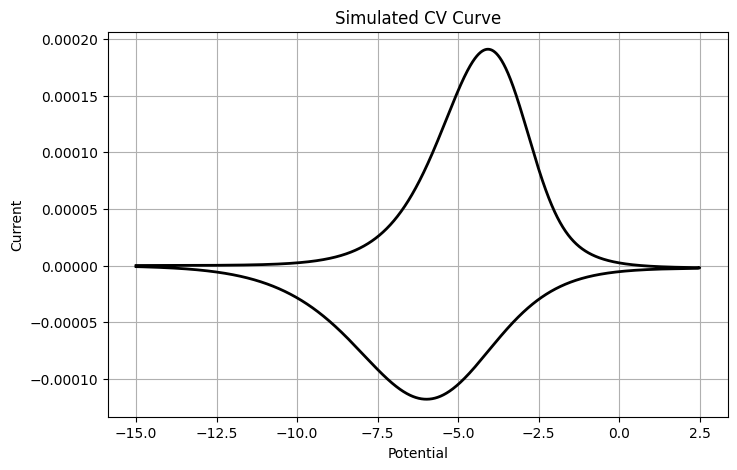

In [145]:
plt.figure(figsize=(8, 5))
plt.plot(epsilon, I , '-',color='black', linewidth=2)
plt.xlabel("Potential")
plt.ylabel("Current")
plt.title("Simulated CV Curve")
plt.grid(True)


plt.show()


# Test the Tablot inverse transform

Depois estudar para entender melhor como funciona

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def Talbot(F, t_vals, N=16):
    """
    Computes the inverse Laplace transform using Talbot's method for multiple time values.

    Parameters:
        F (callable): Function in the Laplace domain F(s).
        t_vals (array-like): Array of time values to evaluate the inverse transform.
        N (int): Number of terms in the summation (higher = better accuracy).

    Returns:
        np.ndarray: Approximated inverse Laplace transform values for all `t_vals`.
    """
    t_vals = np.asarray(t_vals, dtype=np.float64)  # Ensure t_vals is a numpy array
    results = np.zeros_like(t_vals, dtype=np.float64)

    h = 2 * np.pi / N  # Step size
    shift = 0.0  # Shift contour if necessary

    # Precompute theta values and cotangent terms
    theta = np.linspace(-np.pi + h / 2, np.pi - h / 2, N)
    cot_term = 1 / np.tan(0.6407 * theta)

    for idx, t in enumerate(t_vals):
        if t <= 0:
            results[idx] = np.nan  # Assign NaN for invalid t values
            continue

        # Compute z and dz for all theta at once
        z = shift + (N / t) * (0.5017 * theta * cot_term - 0.6122 + 0.2645j * theta)
        dz = (N / t) * (-0.5017 * 0.6407 * theta / np.sin(0.6407 * theta) ** 2 + 0.5017 * cot_term + 0.2645j)

        # Compute function values
        Fz = F(z)
        exp_term = np.exp(z * t) * Fz * dz

        # Sum over all terms using vectorized numpy summation
        results[idx] = (h / (2j * np.pi)) * np.sum(exp_term)

    return results.real  # Return only the real part


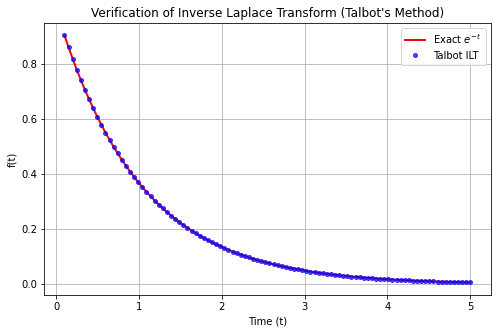

In [16]:
# Define Laplace function F(s) = 1 / (s + 1) (Inverse should be e^(-t))
F_s = lambda s: 1 / (s + 1)

# Time values for inverse transform
t_values = np.linspace(0.1, 5, 100)

# Compute inverse Laplace using Talbot's method
f_t_talbot = Talbot(F_s,t_values,len(t_values)) #talbot_inverse_laplace(F_s, t_values)

# Exact function f(t) = e^(-t)
f_t_exact = np.exp(-t_values)

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(t_values, f_t_exact, 'r-', label="Exact $e^{-t}$", linewidth=2)
plt.plot(t_values, f_t_talbot, 'bo', label="Talbot ILT", markersize=4, alpha=0.7)
plt.xlabel("Time (t)")
plt.ylabel("f(t)")
plt.legend()
plt.title("Verification of Inverse Laplace Transform (Talbot's Method)")
plt.grid(True)
plt.show()